In [122]:
import pandas as pd
import numpy as np
import string as s
import matplotlib.pyplot as plt
import re
import seaborn as sns
import math
import scipy.stats as scs

from pandas.plotting import scatter_matrix
import warnings

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
#from sklearn.cross_validation import KFold

from basis_expansions import NaturalCubicSpline


### Importing .py files available in the SRC folder
from src.data_select import data_select

from src.dftransformers import (ColumnSelector, Identity,
                            FeatureUnion, MapFeature,
                            Intercept)

from src.regression_helpers import (plot_univariate_smooth,
                                bootstrap_train,
                                display_coef,
                                plot_bootstrap_coefs,
                                plot_partial_depenence,
                                plot_partial_dependences,
                                predicteds_vs_actuals)

from src.util import (catagorical_plot, 
                    categorical_plot,
                    simple_spline_specification, 
                    residual_plot,
                    rss,
                    rsq,
                    bootstrap_rsq,
                    rmse, 
                    cv,
                    get_optimal_alpha,
                    train_at_various_alphas,
                    XyScaler)

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# EDA

In [123]:
df2016 = data_select()

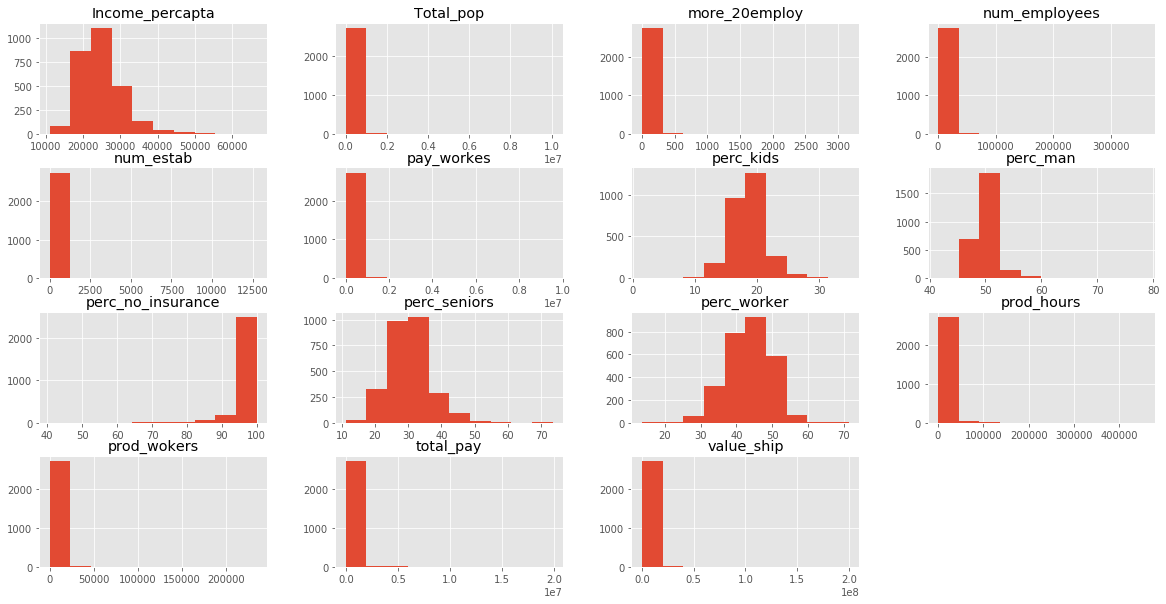

In [124]:
df2016.hist(figsize = (20,10));

In [125]:
states = df2016.groupby(['State'])[['perc_seniors']].mean()
states.sort_values('perc_seniors')

,perc_seniors
State,
District of Columbia,21.40
Alaska,22.24
Utah,23.07
Louisiana,26.67
Mississippi,27.59
New Jersey,27.59
Georgia,27.80
Texas,28.18
Maryland,28.42


Evaluate data from Industry

In [126]:
#Dividing industrial values by population
df2016['estab_pp'] = df2016['num_estab'] / df2016['Total_pop']
df2016['more_20_pp'] = df2016['more_20employ'] / df2016['Total_pop']
df2016['num_emp_pp'] = df2016['num_employees'] / df2016['Total_pop']
df2016['tot_pay_pp'] = df2016['total_pay'] / df2016['Total_pop']
df2016['prod_h_pp'] = df2016['prod_hours'] / df2016['Total_pop']
df2016['pay_work_pp'] = df2016['pay_workes'] / df2016['Total_pop']
df2016['value_sh_pp'] = df2016['value_ship'] / df2016['Total_pop']

In [127]:
df2016 = df2016[['Id', 'County', 'State', 'Size_County', 'Total_pop',
                 'Income_percapta', 'estab_pp', 'more_20_pp', 'num_emp_pp', 
                 'tot_pay_pp', 'prod_h_pp', 'pay_work_pp', 'value_sh_pp','perc_man', 
                 'perc_kids', 'perc_worker','perc_no_insurance','perc_seniors']]

In [128]:
df2016.describe()

,Total_pop,Income_percapta,estab_pp,more_20_pp,num_emp_pp,tot_pay_pp,prod_h_pp,pay_work_pp,value_sh_pp,perc_man,perc_kids,perc_worker,perc_no_insurance,perc_seniors
count,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00,2762.00
mean,114804.86,25009.84,0.00,0.00,0.04,1.85,0.06,1.19,15.58,49.91,18.69,43.52,97.50,30.33
std,344704.38,5978.14,0.00,0.00,0.04,1.81,0.06,1.22,28.66,2.12,2.84,6.19,3.87,6.13
min,5020.00,11114.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41.50,1.50,13.60,40.68,11.20
25%,15522.75,20988.50,0.00,0.00,0.01,0.55,0.02,0.32,0.00,48.90,17.00,39.40,97.84,26.50
50%,32021.50,24178.00,0.00,0.00,0.03,1.38,0.05,0.86,7.70,49.50,18.60,43.74,98.74,30.10
75%,80161.75,27849.50,0.00,0.00,0.06,2.63,0.09,1.66,20.08,50.40,20.20,48.08,99.12,33.70
max,10057155.00,66522.00,0.01,0.00,0.37,16.45,0.76,11.24,553.52,78.50,34.80,71.46,100.00,73.50


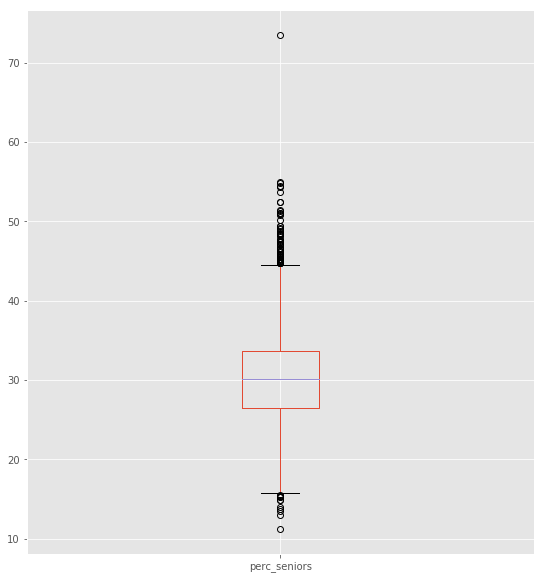

In [129]:
fig = plt.figure(figsize=(20,10)) # Define o tamanho da área de plotagem
ax1 = fig.add_subplot(1,2,1) # Define o Gráfico
df2016['perc_seniors'].plot(kind='box');
plt.savefig('images/box01.png')

# Identify and Delete Outliers

In [130]:
#Show Outliers (More than 4 standard deviations)
cond1 = df2016['perc_seniors'] < 5.81
cond2 = df2016['perc_seniors'] > 54.85
df2016[cond1 | cond2]

,Id,County,State,Size_County,Total_pop,Income_percapta,estab_pp,more_20_pp,num_emp_pp,tot_pay_pp,prod_h_pp,pay_work_pp,value_sh_pp,perc_man,perc_kids,perc_worker,perc_no_insurance,perc_seniors
288,12015.00,Charlotte,Florida,County over 50k people,169642.00,27860.00,0.00,0.00,0.00,0.09,0.00,0.04,0.53,48.70,10.60,33.77,98.00,55.00
339,12119.00,Sumter,Florida,County over 50k people,113589.00,31591.00,0.00,0.00,0.01,0.36,0.01,0.23,4.07,50.60,6.20,20.47,91.82,73.50


In [131]:
#Delete Outliers
cond1 = df2016['perc_seniors'] >= 5.81
cond2 = df2016['perc_seniors'] <= 54.85
df2016 = df2016[cond1 & cond2]

In [132]:
df2016['perc_seniors'].describe()

count   2760.00
mean      30.31
std        6.06
min       11.20
25%       26.50
50%       30.05
75%       33.70
max       54.80
Name: perc_seniors, dtype: float64

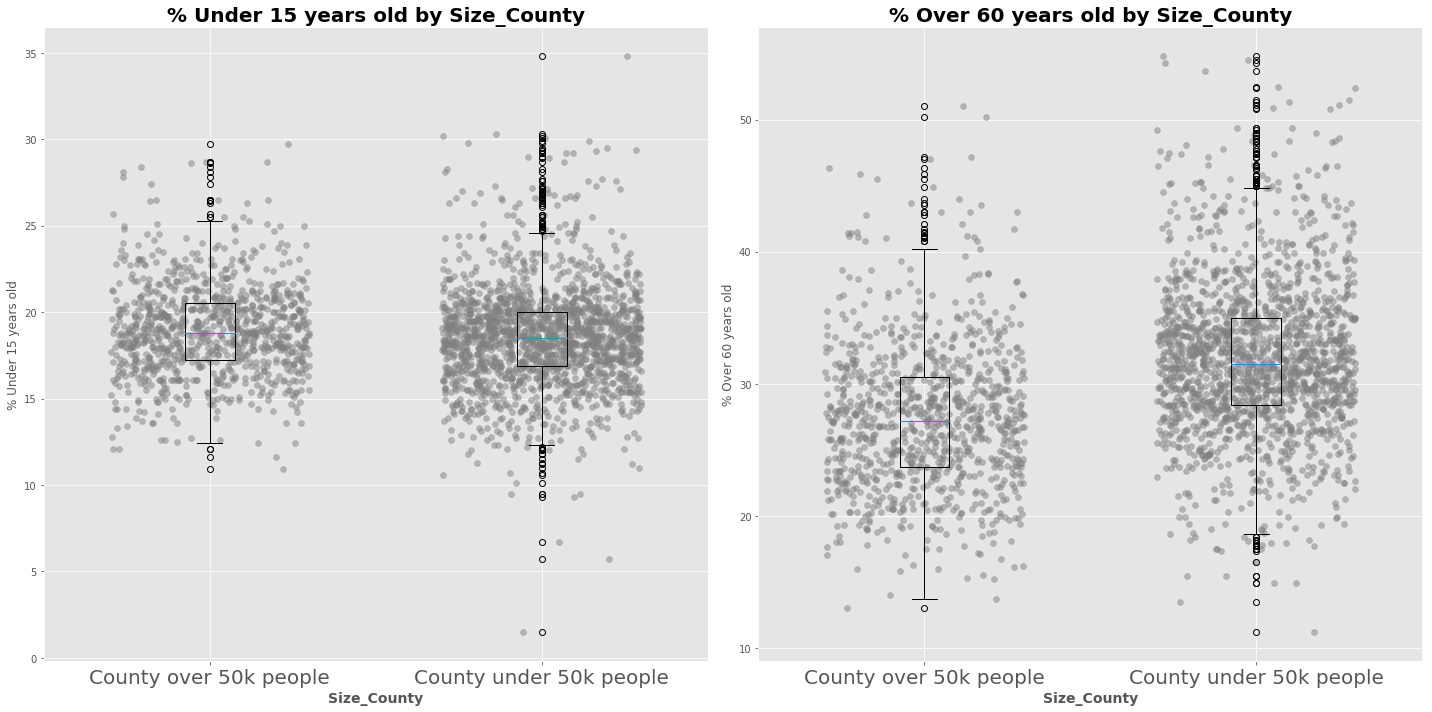

In [133]:
fig = plt.figure(figsize=(20,10)) # Define o tamanho da área de plotagem
ax1 = fig.add_subplot(1,2,1) # Define o Gráfico
ax2 = fig.add_subplot(1,2,2) # Define o Gráfico
categorical_plot(df2016, ax1, 'Size_County','perc_kids','% Under 15 years old')
categorical_plot(df2016, ax2, 'Size_County','perc_seniors','% Over 60 years old')
fig.tight_layout()
plt.savefig('images/compare.png')

In [134]:
Size_county = df2016.groupby(['Size_County']).mean()
pd.options.display.float_format = '{:,.4f}'.format
Size_county[['Total_pop','perc_man','perc_kids','perc_seniors']]

,Total_pop,perc_man,perc_kids,perc_seniors
Size_County,,,,
County over 50k people,"284,384.9213",49.3496,18.9646,27.4079
County under 50k people,"21,705.5730",50.2147,18.5466,31.8959


In [135]:
small_county = df2016[df2016['Size_County'] == 'County under 50k people']
big_county = df2016[df2016['Size_County'] == 'County over 50k people']

# Hypothesis Testing - % Kids

    H0: Mean % Kids of Small County == Mean % Kids of Big County

    H1: Mean % Kids of Small Couty != Mean % Kids of Big County

In [136]:
# check with scipy.stats
scs.ttest_ind(small_county['perc_kids'], big_county['perc_kids'])

Ttest_indResult(statistic=-3.7238516758300588, pvalue=0.00020013455574895085)

# Hypothesis Testing - % Seniors

In [137]:
mean_small_county = small_county['perc_seniors'].mean()
mean_big_county = big_county['perc_seniors'].mean()
var_small_county = small_county['perc_seniors'].var()
var_big_county = big_county['perc_seniors'].var()
num_small_county = small_county['perc_seniors'].count()
num_big_county = big_county['perc_seniors'].count()

print ('% Seniors - Small Countys: Mean: {0:0.4f} - Var: {1:0.4f} - N: {2:0.0f}'.format(mean_small_county,var_small_county,num_small_county))
print ('% Seniors - Big Countys: Mean: {0:0.4f} - Var: {1:0.4f} - N: {2:0.0f}'.format(mean_big_county,var_big_county,num_big_county))

% Seniors - Small Countys: Mean: 31.8959 - Var: 33.3748 - N: 1782
% Seniors - Big Countys: Mean: 27.4079 - Var: 29.7975 - N: 978


        H0: Mean % Seniors of Small County == Mean % Seniors of Big County

        H1: Mean % Seniors of Small Couty != Mean % Seniors of Big County

In [138]:
# Manual calculate
t_stat = (mean_big_county - mean_small_county) / math.sqrt(var_big_county/num_big_county + var_small_county/num_small_county)
p_val = 1 - scs.norm.cdf(abs(t_stat))
print('t-stat: {0:0.4f} - P-val: {1:0.3f}'.format(t_stat, p_val))

# check with scipy.stats
scs.ttest_ind(small_county['perc_seniors'], big_county['perc_seniors'])

t-stat: -20.2343 - P-val: 0.000


Ttest_indResult(statistic=19.903106392953489, pvalue=1.7983562580992699e-82)

#            # Reject H0:

            Conclusion: Mean % Seniors of Small Couty != Mean % Seniors of Big County

# EDA

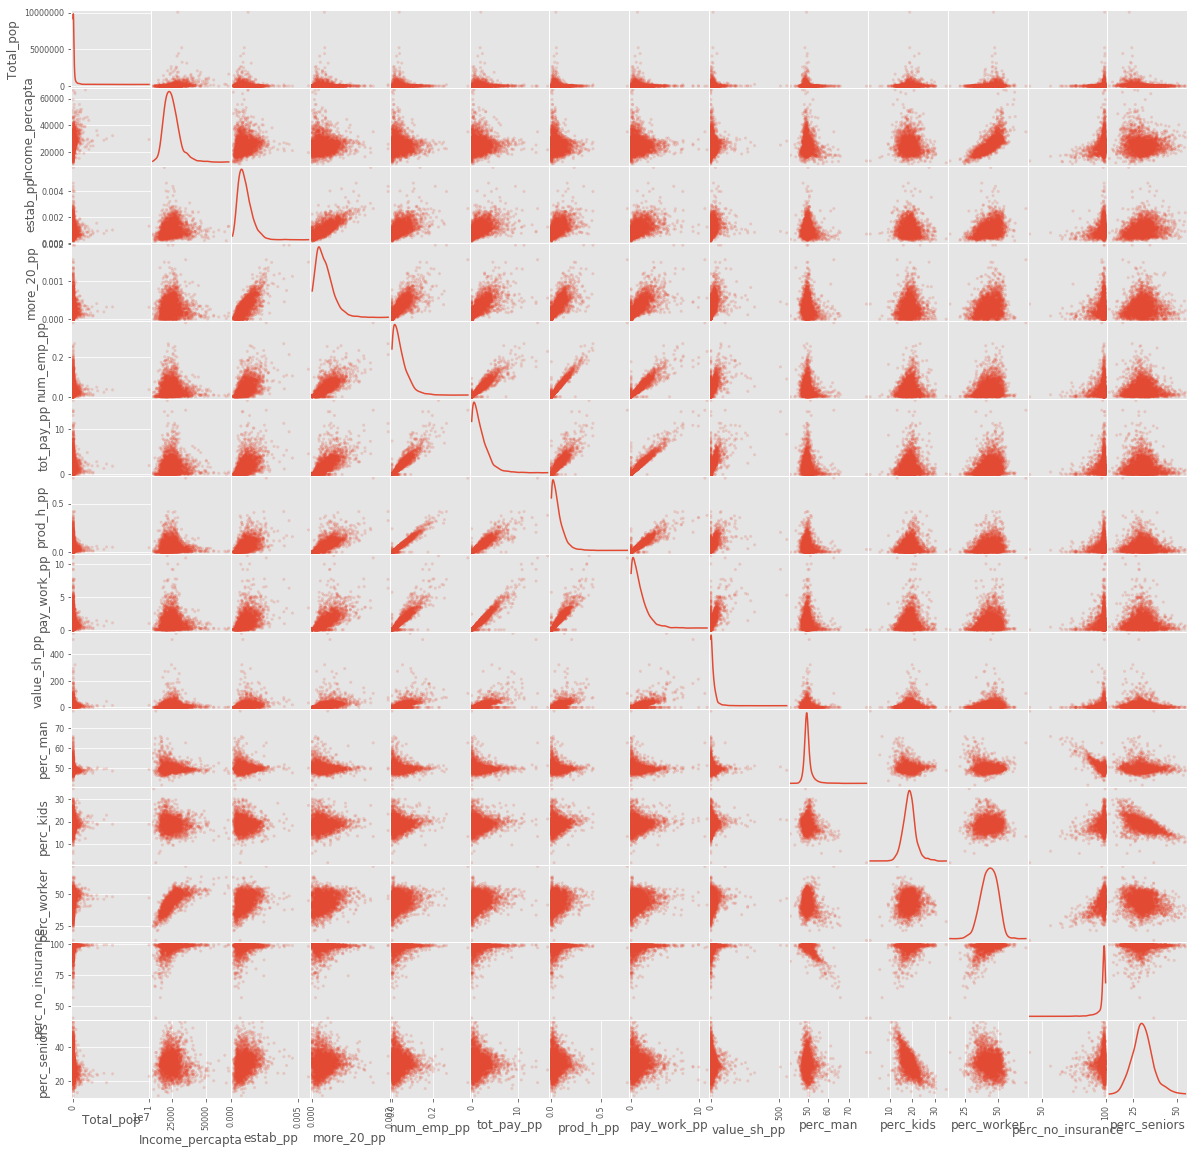

In [62]:
_ = scatter_matrix(df2016, alpha=0.2, figsize=(20, 20), diagonal='kde')

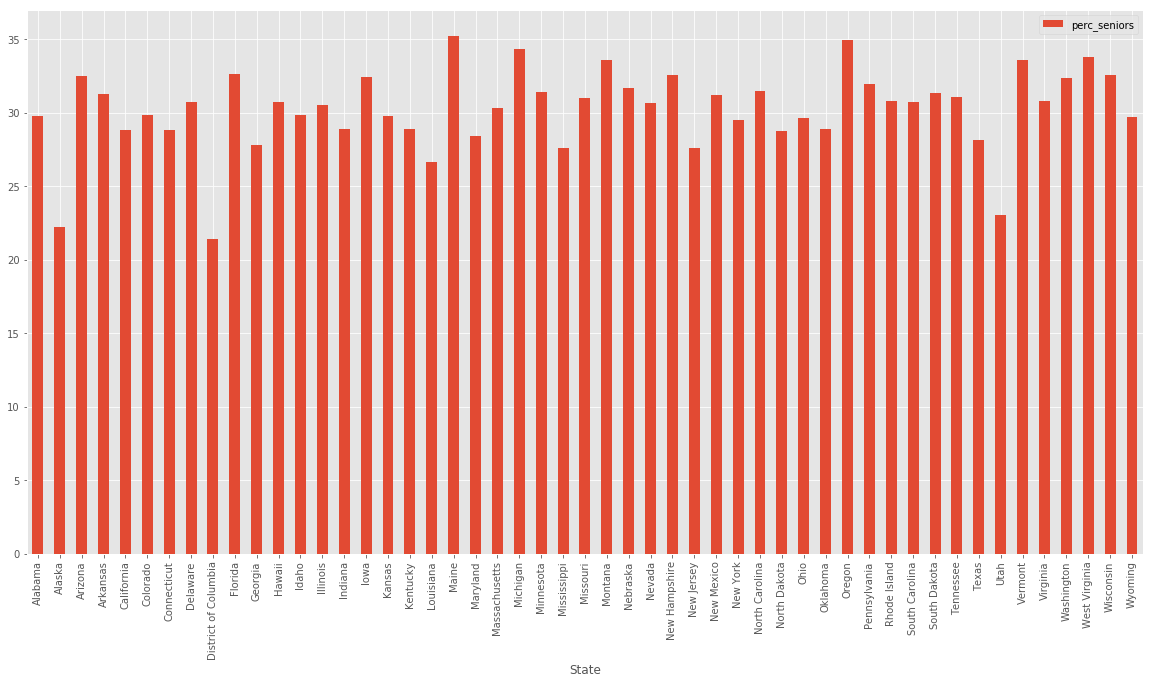

In [139]:
state = df2016.groupby(['State'])[['perc_seniors']].mean()
state.plot(kind='bar',figsize = (20,10))
plt.savefig('images/compare_state.png')

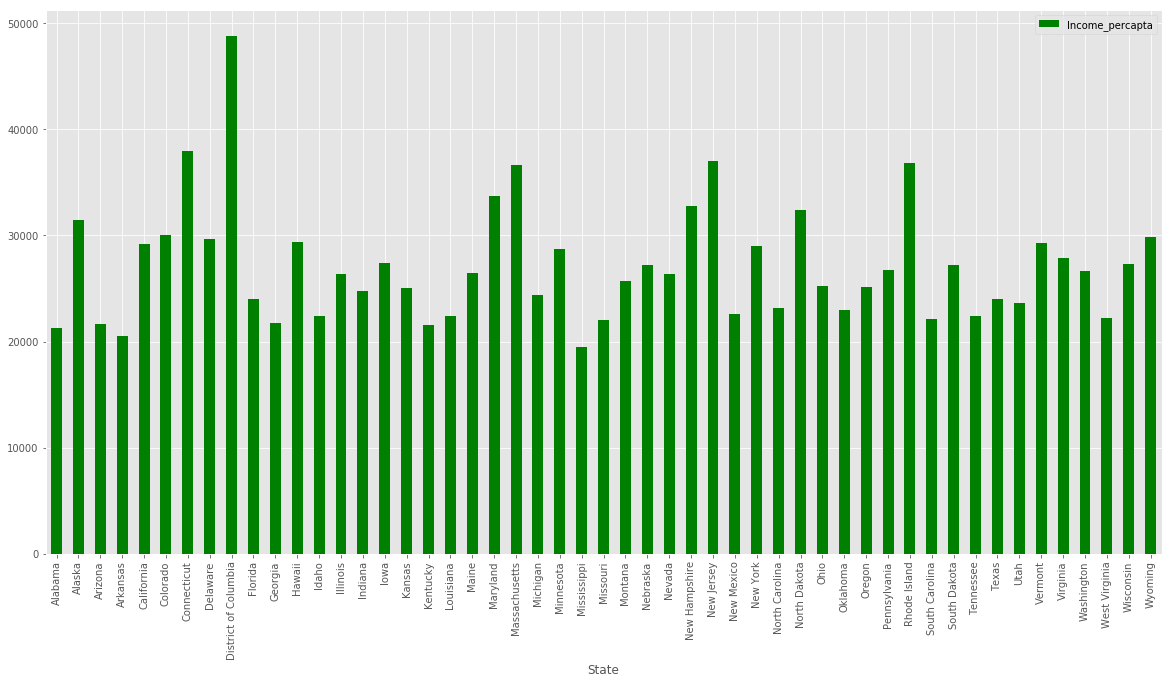

In [140]:
state = df2016.groupby(['State'])[['Income_percapta']].mean()
state.plot(kind='bar',figsize = (20,10),color='g')
plt.savefig('images/compare_state_income.png')

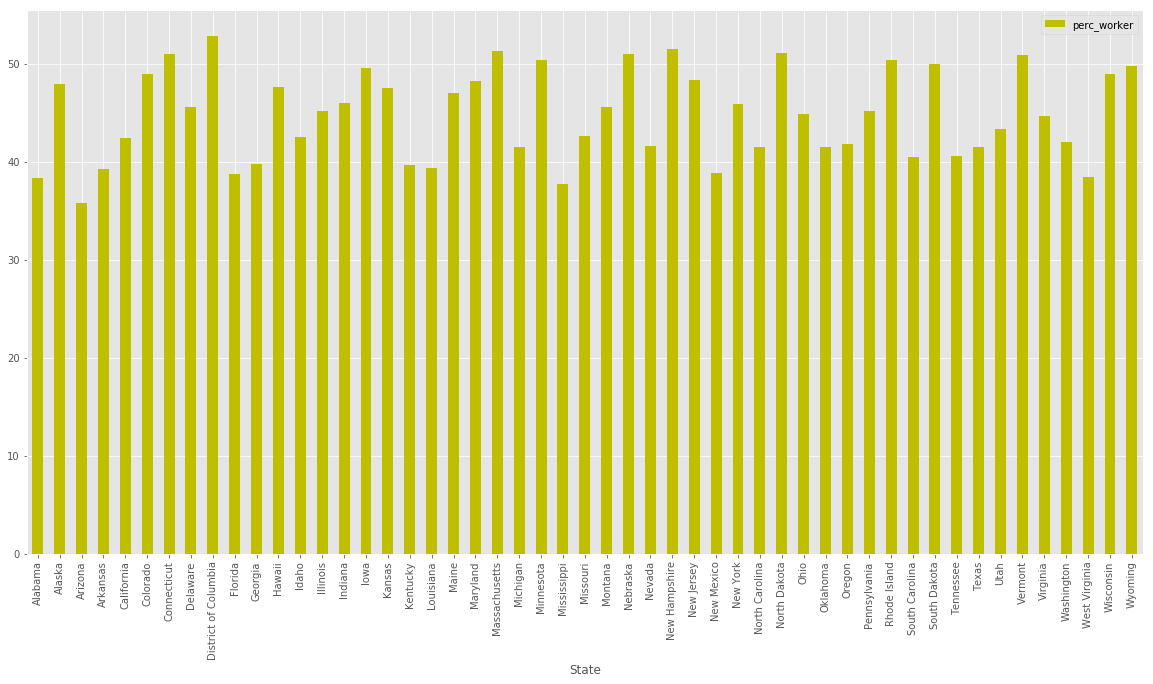

In [141]:
state = df2016.groupby(['State'])[['perc_worker']].mean()
state.plot(kind='bar',figsize = (20,10),color='y')
plt.savefig('images/compare_state_worker.png')

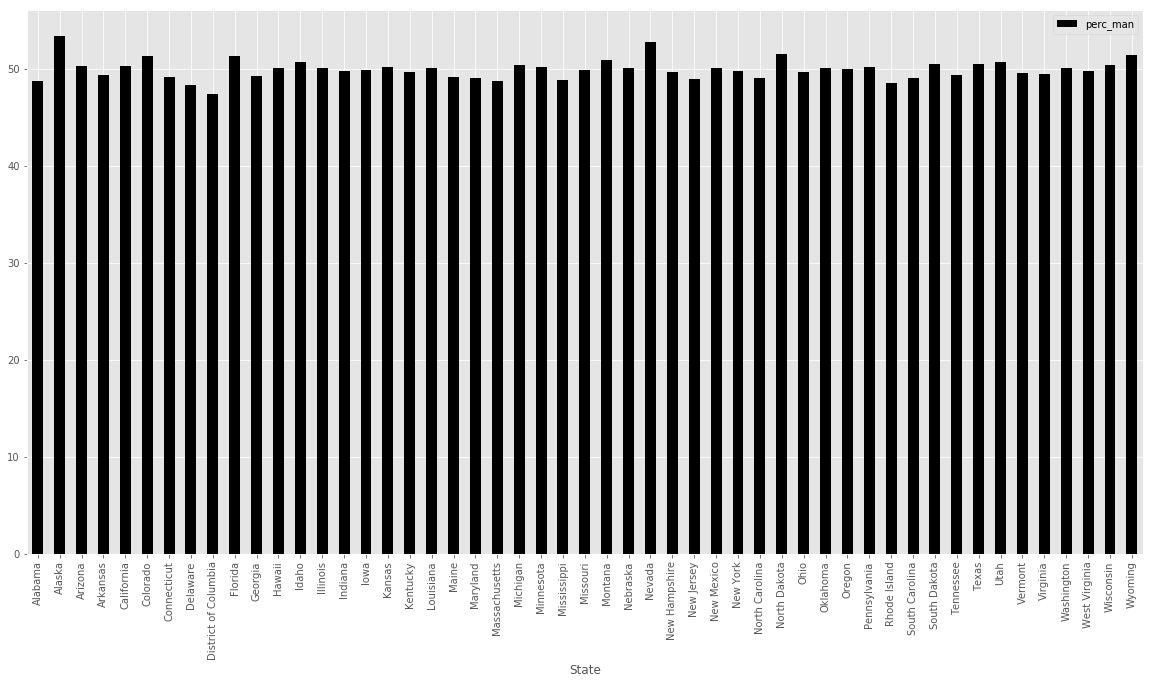

In [142]:
state = df2016.groupby(['State'])[['perc_man']].mean()
state.plot(kind='bar',figsize = (20,10),color='black')
plt.savefig('images/compare_state_man.png')

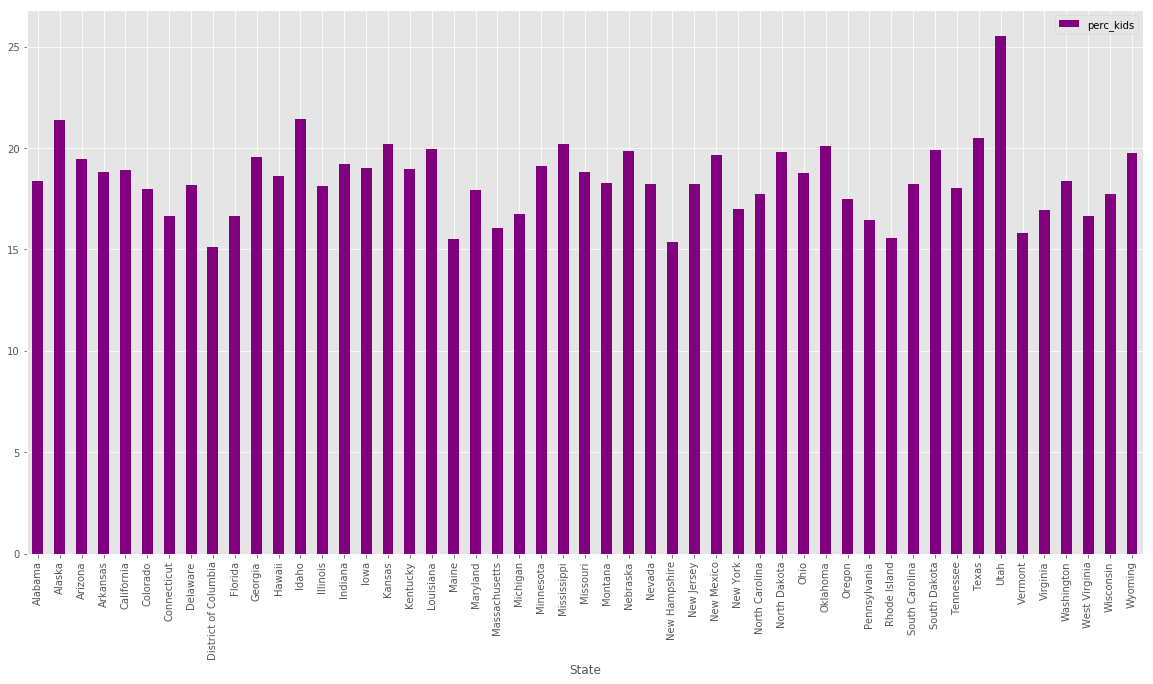

In [143]:
state = df2016.groupby(['State'])[['perc_kids']].mean()
state.plot(kind='bar',figsize = (20,10),color='purple')
plt.savefig('images/compare_state_kids.png')

# Model

In [144]:
df2016.head()

,Id,County,State,Size_County,Total_pop,Income_percapta,estab_pp,more_20_pp,num_emp_pp,tot_pay_pp,prod_h_pp,pay_work_pp,value_sh_pp,perc_man,perc_kids,perc_worker,perc_no_insurance,perc_seniors
0,"1,001.0000",Autauga,Alabama,County over 50k people,"55,049.0000","26,168.0000",0.0004,0.0001,0.0171,1.0448,0.0273,0.7562,12.0964,48.8000,20.4000,44.0735,98.7974,24.4000
1,"1,003.0000",Baldwin,Alabama,County over 50k people,"199,510.0000","28,069.0000",0.0007,0.0002,0.0189,0.8359,0.0290,0.5350,7.2115,48.8000,18.3000,43.9843,98.7650,32.9000
2,"1,005.0000",Barbour,Alabama,County under 50k people,"26,614.0000","17,249.0000",0.0009,0.0004,0.1066,3.8827,0.1684,2.5114,27.6207,53.5000,17.9000,33.7905,88.9832,28.7000
3,"1,007.0000",Bibb,Alabama,County under 50k people,"22,572.0000","18,988.0000",0.0007,0.0001,0.0125,0.4766,0.0220,0.3810,5.2050,53.5000,17.0000,37.0105,91.2547,26.3000
4,"1,009.0000",Blount,Alabama,County over 50k people,"57,704.0000","21,033.0000",0.0007,0.0002,0.0216,0.7081,0.0230,0.3609,5.9436,49.5000,19.5000,37.4203,99.2219,30.4000


In [145]:
numeric_predictors = ['Income_percapta','estab_pp', 'more_20_pp', 'num_emp_pp', 
                   'tot_pay_pp', 'prod_h_pp', 'pay_work_pp', 'value_sh_pp','perc_man',
                   'perc_worker','perc_no_insurance','perc_kids','Total_pop']

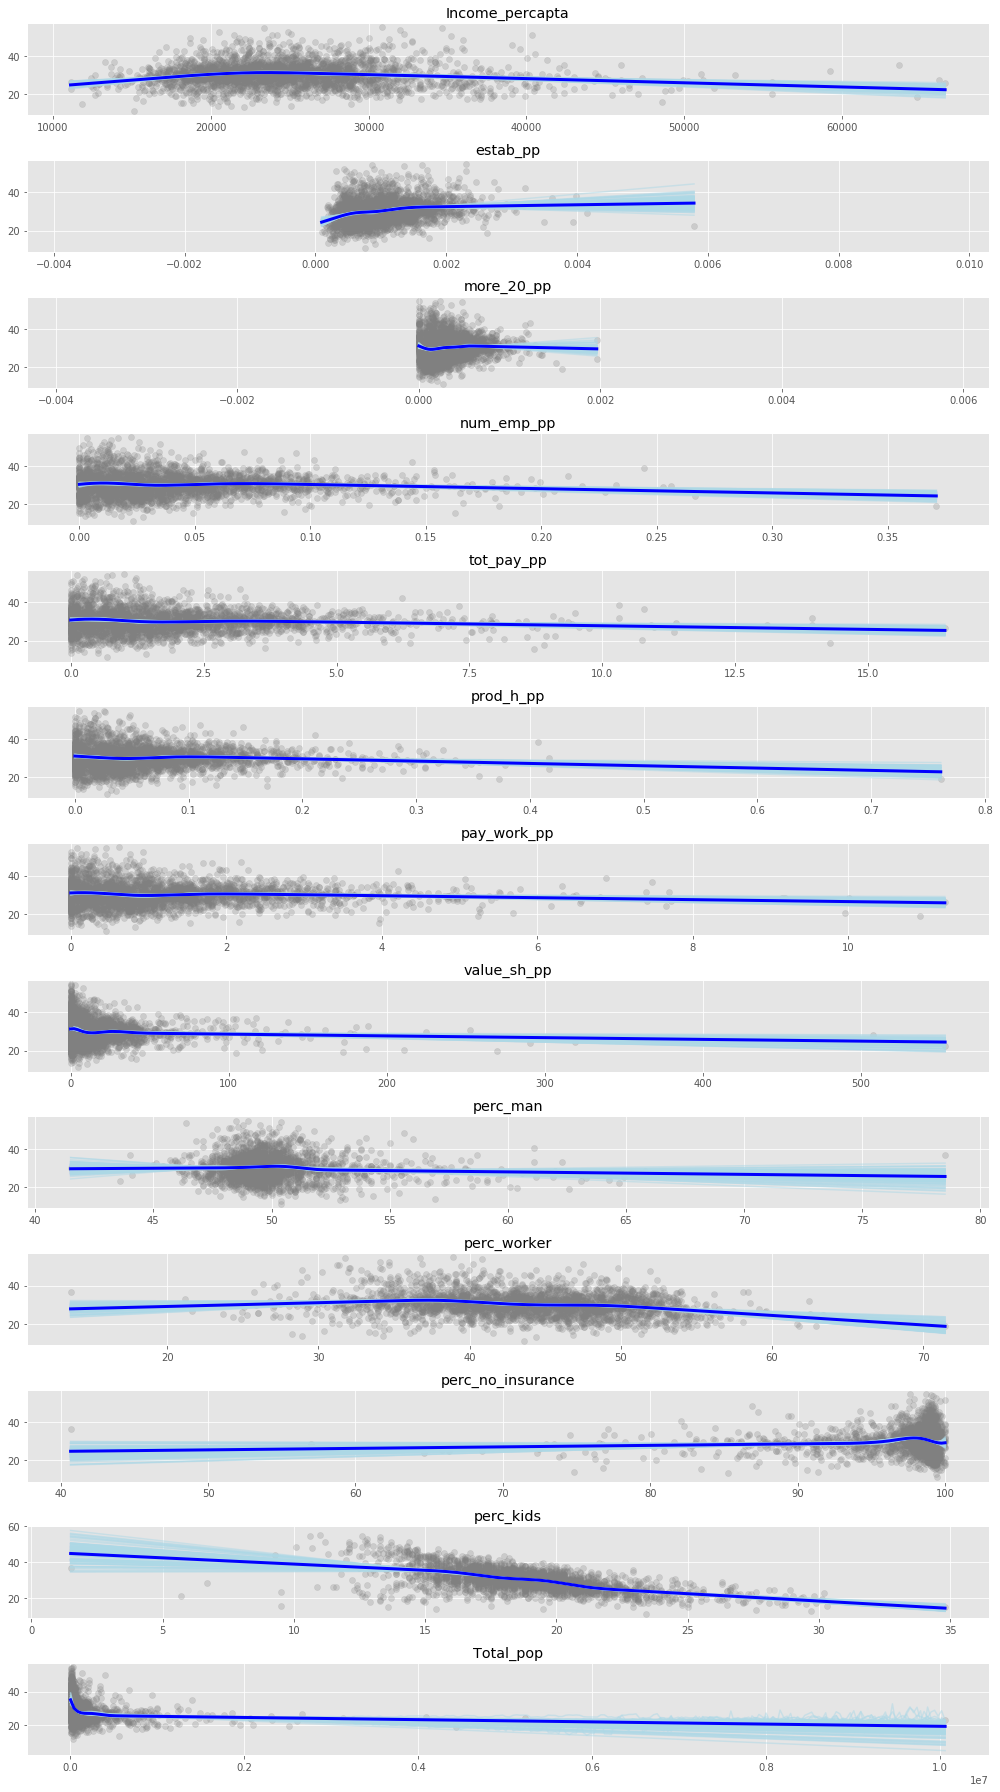

In [146]:
fig, axs = plt.subplots(len(numeric_predictors), figsize=(14, 25))

for name, ax in zip(numeric_predictors, axs.flatten()):
    plot_univariate_smooth(ax, 
                           df2016[name].values.reshape(-1, 1),
                           df2016['perc_seniors'],
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()
plt.savefig('images/smooth.png')

# Separating training base and test base

In [147]:
#['Income_percapta','perc_man','perc_worker','perc_no_insurance','perc_kids','Total_pop']
#numeric_predictors = ['Income_percapta','perc_man','perc_worker','perc_no_insurance','perc_kids','Total_pop']
X = df2016[numeric_predictors] # housing features
y = df2016['perc_seniors'] # housing prices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Ridge

In [148]:
ridge_alphas = np.logspace(-2, 7, num=250)

ridge_cv_errors_train, ridge_cv_errors_test = train_at_various_alphas(
    X_train.values, y_train.values, Ridge, ridge_alphas)

In [149]:
ridge_mean_cv_errors_train = ridge_cv_errors_train.mean(axis=0)
ridge_mean_cv_errors_test = ridge_cv_errors_test.mean(axis=0)

In [150]:
ridge_optimal_alpha = get_optimal_alpha(ridge_mean_cv_errors_test)
print('Log Ridge Optimal Alpha: {0:0.2f}'.format(np.log(ridge_optimal_alpha)))

Log Ridge Optimal Alpha: 2.89


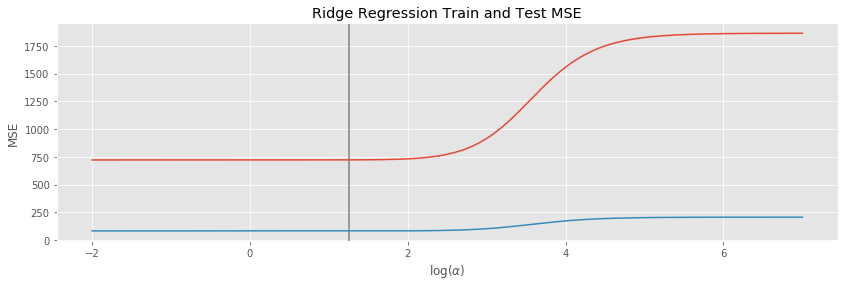

In [151]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_train)
ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_test)
ax.axvline(np.log10(ridge_optimal_alpha), color='grey')
ax.set_title("Ridge Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE");
plt.savefig('images/ridge_error.png')

In [152]:
ridge_models = []

for alpha in ridge_alphas:
    scaler = XyScaler()
    scaler.fit(X_train.values, y_train.values)
    X_train_std, y_train_std = scaler.transform(X_train.values, y_train.values)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_std, y_train_std)
    ridge_models.append(ridge)

In [153]:
paths = pd.DataFrame(np.empty(shape=(len(ridge_alphas), len(X_train.columns))),
                     index=ridge_alphas, columns=X_train.columns)

for idx, model in enumerate(ridge_models):
    paths.iloc[idx] = model.coef_

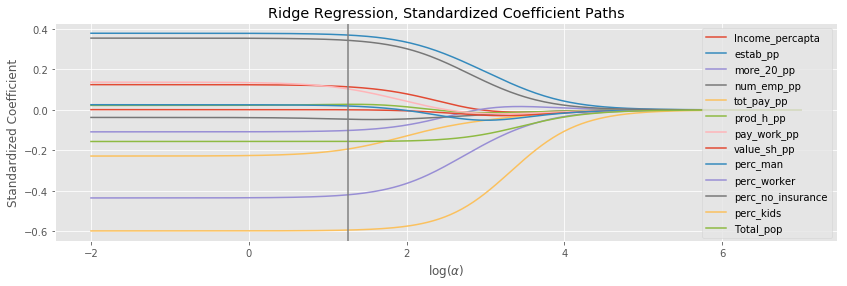

In [154]:
fig, ax = plt.subplots(figsize=(14, 4))

for column in X_train.columns:
    path = paths.loc[:, column]
    ax.plot(np.log10(ridge_alphas), path, label=column)
ax.axvline(np.log10(ridge_optimal_alpha), color='grey')
ax.legend(loc='better')
ax.set_title("Ridge Regression, Standardized Coefficient Paths")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("Standardized Coefficient");
plt.savefig('images/ridge_coef.png')

# Lasso

In [155]:
lasso_alphas = np.logspace(-7, 1, num=250)

lasso_cv_errors_train, lasso_cv_errors_test = train_at_various_alphas(
    X_train.values, y_train.values, Lasso, lasso_alphas, max_iter=5000)

Log Lasso Optimal Alpha: -6.13


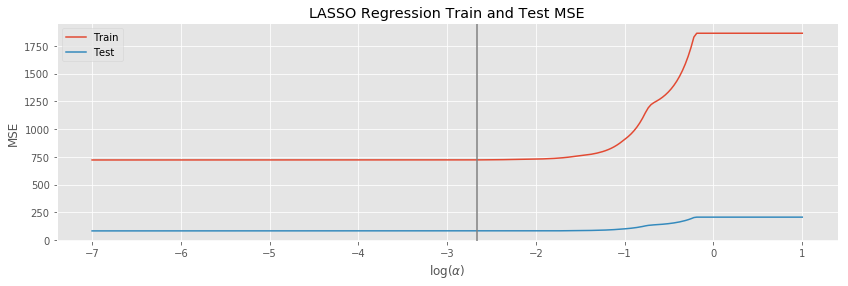

In [156]:
lasso_mean_cv_errors_train = lasso_cv_errors_train.mean(axis=0)
lasso_mean_cv_errors_test = lasso_cv_errors_test.mean(axis=0)

lasso_optimal_alpha = get_optimal_alpha(lasso_mean_cv_errors_test)

print('Log Lasso Optimal Alpha: {0:0.2f}'.format(np.log(lasso_optimal_alpha)))
    
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_train,label='Train')
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_test,label='Test')
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.set_title("LASSO Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")
ax.legend(loc='better');
plt.savefig('images/lasso_error.png')

In [157]:
lasso_models = []

lasso_alphas = np.logspace(-7, 1, num=250)
for alpha in lasso_alphas:
    scaler = XyScaler()
    scaler.fit(X_train.values, y_train.values)
    X_train_std, y_train_std = scaler.transform(X_train.values, y_train.values)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_std, y_train_std)
    lasso_models.append(lasso)

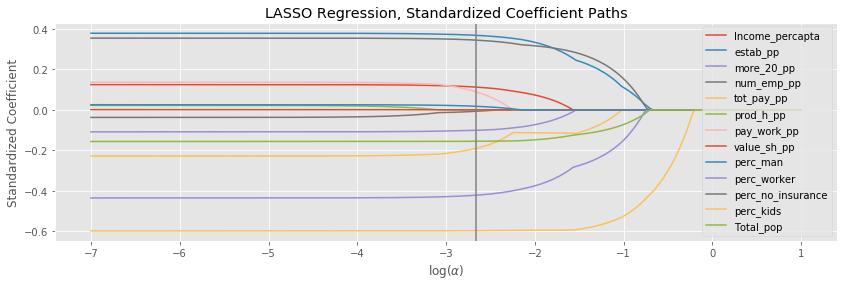

In [158]:
paths = pd.DataFrame(np.empty(shape=(len(lasso_alphas), len(X_train.columns))),
                     index=lasso_alphas, columns=X_train.columns)

for idx, model in enumerate(lasso_models):
    paths.iloc[idx] = model.coef_
    
fig, ax = plt.subplots(figsize=(14, 4))
for column in X_train.columns:
    path = paths.loc[:, column]
    ax.plot(np.log10(lasso_alphas), path, label=column)
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.legend(loc='lower right')
ax.set_title("LASSO Regression, Standardized Coefficient Paths")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("Standardized Coefficient");
plt.savefig('images/lasso_coef.png')

# Comparing Models Ridge, Lasso and Linear Regression

In [189]:
final_ridge = Ridge(alpha=ridge_optimal_alpha).fit(X_train, y_train)
final_lasso = Lasso(alpha=lasso_optimal_alpha).fit(X_train, y_train)
final_lr = LinearRegression(normalize=True).fit(X_train, y_train)

In [190]:
#final_ridge_rss = rss(y_test_std, final_ridge.predict(X_test_std))
#final_lasso_rss = rss(y_test_std, final_lasso.predict(X_test_std))
#final_lr_rss = rss(y_test_std, final_lr.predict(X_test_std))

final_ridge_mse = mean_squared_error(y_test, final_ridge.predict(X_test))
final_lasso_mse = mean_squared_error(y_test, final_lasso.predict(X_test))
final_lr_mse = mean_squared_error(y_test, final_lr.predict(X_test))

In [197]:
#print("Final Ridge RSS: {:2.3f}".format(final_ridge_rss))
#print("Final Lasso RSS: {:2.3f}".format(final_lasso_rss))
#print("Final Linear Regression RSS: {:2.3f}".format(final_lr_rss))
#print("\n")
print("Final Ridge MSE: {:2.2f}".format(final_ridge_mse))
print("Final Lasso MSE: {:2.2f}".format(final_lasso_mse))
print("Final Linear Regression MSE: {:2.2f}".format(final_lr_mse))

Final Ridge MSE: 18.04
Final Lasso MSE: 17.89
Final Linear Regression MSE: 15.46


In [192]:
print("{:<35}{:<20}".format("Name", "Parameter Estimate"))
print("-"*(35 + 20))

for coef, name in zip(final_lr.coef_, df2016[numeric_predictors]):
        row = "{0:<35}{1:0.3f}".format(name, coef)
        print(row)

Name                               Parameter Estimate  
-------------------------------------------------------
Income_percapta                    0.000
estab_pp                           4464.148
more_20_pp                         -2881.472
num_emp_pp                         -6.125
tot_pay_pp                         -0.772
prod_h_pp                          2.262
pay_work_pp                        0.688
value_sh_pp                        0.000
perc_man                           0.078
perc_worker                        -0.433
perc_no_insurance                  0.592
perc_kids                          -1.286
Total_pop                          -0.000


# Cross Validation - Linear Regression

In [185]:
df2016_model = LinearRegression(fit_intercept=False,normalize=True)
df2016_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [196]:
num_folds = 10
kf = KFold(n_splits=num_folds)
error = np.empty(num_folds) # Já cria os espaços na lista antecipadamente para poder se trabalhar com indíces
error_rss = np.empty(num_folds) # Já cria os espaços na lista antecipadamente para poder se trabalhar com indíces
index = 0
linear_cv = LinearRegression()
for train, test in kf.split(X_train):    # Com os dados separados em partes se faz o treino e checa o resultado para dada dobra
    linear_cv.fit(X_train.iloc[train], y_train.iloc[train])
    pred = linear_cv.predict(X_train.iloc[test])
    error[index] = np.sqrt(mean_squared_error(y_train.iloc[test],pred))
    error_rss[index] = rss(y_train.iloc[test],pred)
    index += 1

final_cv_rss = rss(y_test, linear_cv.predict(X_test))
final_cv_mse = mean_squared_error(y_test, linear_cv.predict(X_test))
#print('Cross-Validation RSS: {0:0.5f}'.format(final_cv_rss))
print('Cross-Validation MSE: {0:0.2f}'.format(final_cv_mse))

Cross-Validation MSE: 15.46


In [187]:
print("{:<35}{:<20}".format("Name", "Parameter Estimate"))
print("-"*(35 + 20))

for coef, name in zip(final_lr.coef_, df2016[numeric_predictors]):
        row = "{0:<35}{1:0.3f}".format(name, coef)
        print(row)

Name                               Parameter Estimate  
-------------------------------------------------------
Income_percapta                    0.000
estab_pp                           4464.148
more_20_pp                         -2881.472
num_emp_pp                         -6.125
tot_pay_pp                         -0.772
prod_h_pp                          2.262
pay_work_pp                        0.688
value_sh_pp                        0.000
perc_man                           0.078
perc_worker                        -0.433
perc_no_insurance                  0.592
perc_kids                          -1.286
Total_pop                          -0.000


# Evaluating the Models for Train part

In [195]:
train_ridge_mse = mean_squared_error(y_train, final_ridge.predict(X_train))
train_lasso_mse = mean_squared_error(y_train, final_lasso.predict(X_train))
train_lr_mse = mean_squared_error(y_train, final_lr.predict(X_train))
train_cv_mse = mean_squared_error(y_train, linear_cv.predict(X_train))

print("All data Ridge MSE: {:2.2f}".format(train_ridge_mse))
print("All data Lasso MSE: {:2.2f}".format(train_lasso_mse))
print("All data Linear Regression MSE: {:2.2f}".format(train_lr_mse))
print("All data Cross Validation MSE: {:2.2f}".format(train_cv_mse))

All data Ridge MSE: 16.94
All data Lasso MSE: 16.84
All data Linear Regression MSE: 14.43
All data Cross Validation MSE: 14.44


# Evaluating the Models for the entire dataset

In [194]:
X_all = df2016[numeric_predictors]
y_all = df2016['perc_seniors']

all_ridge_mse = mean_squared_error(y_all, final_ridge.predict(X_all))
all_lasso_mse = mean_squared_error(y_all, final_lasso.predict(X_all))
all_lr_mse = mean_squared_error(y_all, final_lr.predict(X_all))
all_cv_mse = mean_squared_error(y_all, linear_cv.predict(X_all))

print("All data Ridge MSE: {:2.2f}".format(all_ridge_mse))
print("All data Lasso MSE: {:2.2f}".format(all_lasso_mse))
print("All data Linear Regression MSE: {:2.2f}".format(all_lr_mse))
print("All data Cross Validation MSE: {:2.2f}".format(all_cv_mse))

All data Ridge MSE: 17.22
All data Lasso MSE: 17.11
All data Linear Regression MSE: 14.69
All data Cross Validation MSE: 14.70
